In [1]:
### reference: https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial#3D-plotting-the-scan

In [2]:
%matplotlib inline

import numpy as np
import SimpleITK as sitk
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage import measure

from utils import load_scan, plot_3d

INPUT_FOLDER = r'D:/masters_datasets/LUNA16-original/LUNA16_Images/*.mhd'
exams = glob.glob(INPUT_FOLDER)
print(len(exams))
exams.sort()

888


In [3]:
itkimage = sitk.ReadImage(exams[21])
ct_scan = sitk.GetArrayFromImage(itkimage)
origin = np.array(list(reversed(itkimage.GetOrigin())))
spacing = np.array(list(reversed(itkimage.GetSpacing())))

#### Loading the files

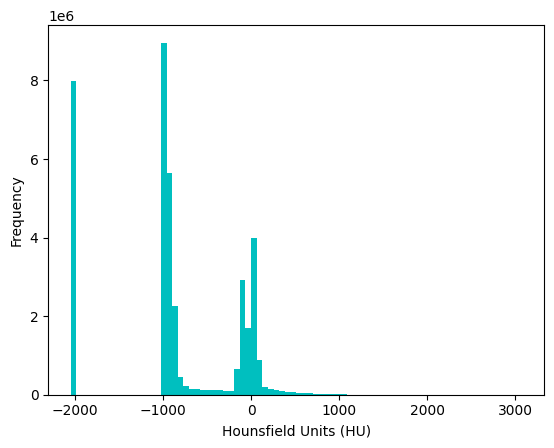

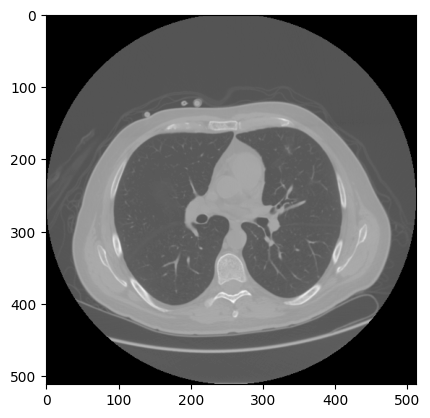

In [4]:
first_exam_pixels = load_scan(exams[10])
plt.hist(first_exam_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(first_exam_pixels[80], cmap=plt.cm.gray)
plt.show()



#### 3D plotting the scan

In [5]:
# plot_3d(first_exam_pixels, 400) ### show bones

#### Lung segmentation

In [6]:
def largest_label_volume(im, bg=-1):
  vals, counts = np.unique(im, return_counts=True)

  counts = counts[vals != bg]
  vals = vals[vals != bg]

  if len(counts) > 0:
    return vals[np.argmax(counts)]
  else:
    return None
  
def segment_lung_mask(image, fill_lung_structures=True):
    
  # not actually binary, but 1 and 2. 
  # 0 is treated as background, which we do not want
  binary_image = np.array(image > -320, dtype=np.int8)+1
  labels = measure.label(binary_image)
  
  # Pick the pixel in the very corner to determine which label is air.
  #   Improvement: Pick multiple background labels from around the patient
  #   More resistant to "trays" on which the patient lays cutting the air 
  #   around the person in half
  background_label = labels[0,0,0]
  
  #Fill the air around the person
  binary_image[background_label == labels] = 2
  
  
  # Method of filling the lung structures (that is superior to something like 
  # morphological closing)
  if fill_lung_structures:
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)
      
      if l_max is not None: #This slice contains some lung
        binary_image[i][labeling != l_max] = 1

  
  binary_image -= 1 #Make the image actual binary
  binary_image = 1-binary_image # Invert it, lungs are now 1
  
  # Remove other air pockets insided body
  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None: # There are air pockets
    binary_image[labels != l_max] = 0

  return binary_image

### unique plot

In [7]:
segmented_lungs = segment_lung_mask(first_exam_pixels, False)
segmented_lungs_fill = segment_lung_mask(first_exam_pixels, True)

In [8]:
# plot_3d(segmented_lungs, 0)

In [9]:
print(np.unique(segmented_lungs_fill, return_counts=True))
print(type(segmented_lungs_fill))
print(segmented_lungs_fill.shape)
print(np.max(segmented_lungs_fill))
print(np.min(segmented_lungs_fill))

(array([0, 1], dtype=int8), array([33228157,  4258435], dtype=int64))
<class 'numpy.ndarray'>
(143, 512, 512)
1
0


In [10]:
# plot_3d(segmented_lungs_fill, 0)

In [11]:
# plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### Batch visualization

In [12]:
for i in tqdm(range(231, 887)):
    current_exam = load_scan(exams[i])
    segmented_lungs_fill = segment_lung_mask(current_exam, True)
    output = np.unique(segmented_lungs_fill, return_counts=True)
    name = str(i) + '-' + str(round(output[1][1]/output[1][0], 5))
    plot_3d(segmented_lungs_fill, threshold=0, name='visualization/'+name)

100%|██████████| 656/656 [16:35:25<00:00, 91.04s/it]    
